<a href="https://colab.research.google.com/github/btcain44/Applied_Deep_Learning/blob/main/Edge_Detection_Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Bi-Weekly Report #4
### Brian Cain
#### Edge_Detection_Ensemble.ipynb

This notebook is inspired by the <b>Robustness</b> module covered in class. It aims to try a new concept, which is making a network more generalizable by performing transformations on input images to enhance certain image characteristics before the model even starts training. 

I have decided to use the Fashion MNIST dataset as I have yet to play around with it so far this semester. I got pretty used to using RGB images from the CIFAR-10 and CIFAR-100 datasets so it will be beneficial to dive back into gray-scale images for a little. 

First, I will perform some EDA to get more comfortable with the dataset and decide what image transformations I'd like to apply to the input images. 

I will reference the following about labels and associated classes from the picture below in the keras documentation:
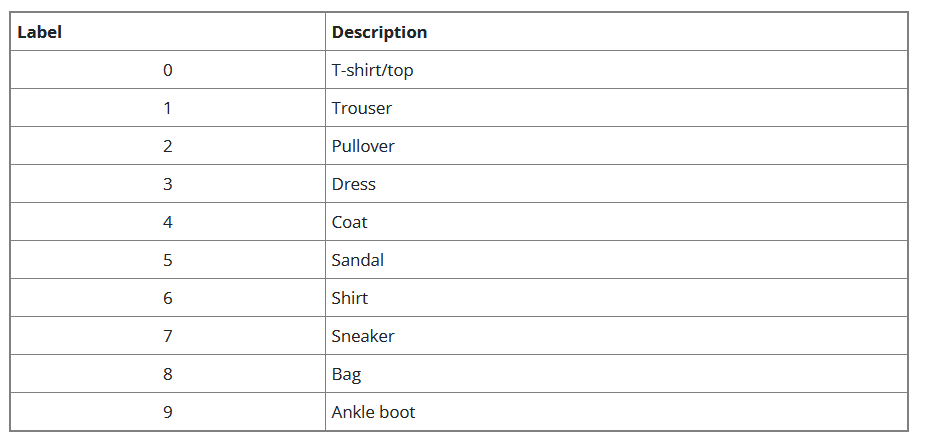

#### <b>Exploration Data Analysis:</b>

In [ ]:
##Import necessary packages
import numpy as np
import tensorflow as tf

##Import the fashion mnist dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

4431872/4422102 [==============================] - 0s 0us/step


Lets explore how many classes there are in the training dataset and determine the class balance within the training data. 

Total Number of Classes we'd like to Predict
10




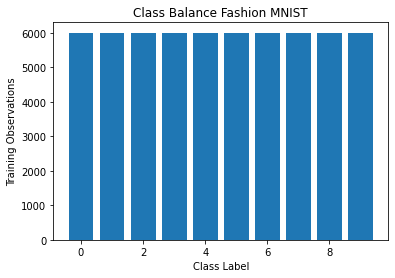

In [ ]:
##Determine how many unique classes there are in the training dataset
print("Total Number of Classes we'd like to Predict")
print(len(np.unique(y_train)))
print('\n')

##Now display how many training examples each unique class has
class_representation = {}
for i in np.unique(y_train):
  class_indices = [i[0] for i in np.argwhere(y_train == i)]
  class_count = len(class_indices)
  class_representation[i] = class_count

##Now plot the class balance
import matplotlib.pyplot as plt
x_data = [i[0] for i in class_representation.items()]
y_data = [i[1] for i in class_representation.items()]
plt.bar(x_data, y_data)
plt.xlabel('Class Label')
plt.ylabel('Training Observations')
plt.title('Class Balance Fashion MNIST')
plt.show()

The information displayed above makes this a convienent dataset. We have 10 labels to predict and each label has equal representation in the training set. This means that I don't have to conduct any class re-balancing to prevent a model from becoming more biased towards certain classes with higher representation in the training dataset. 

Now lets take a look at random images from each class to get a sense of what each class looks like:

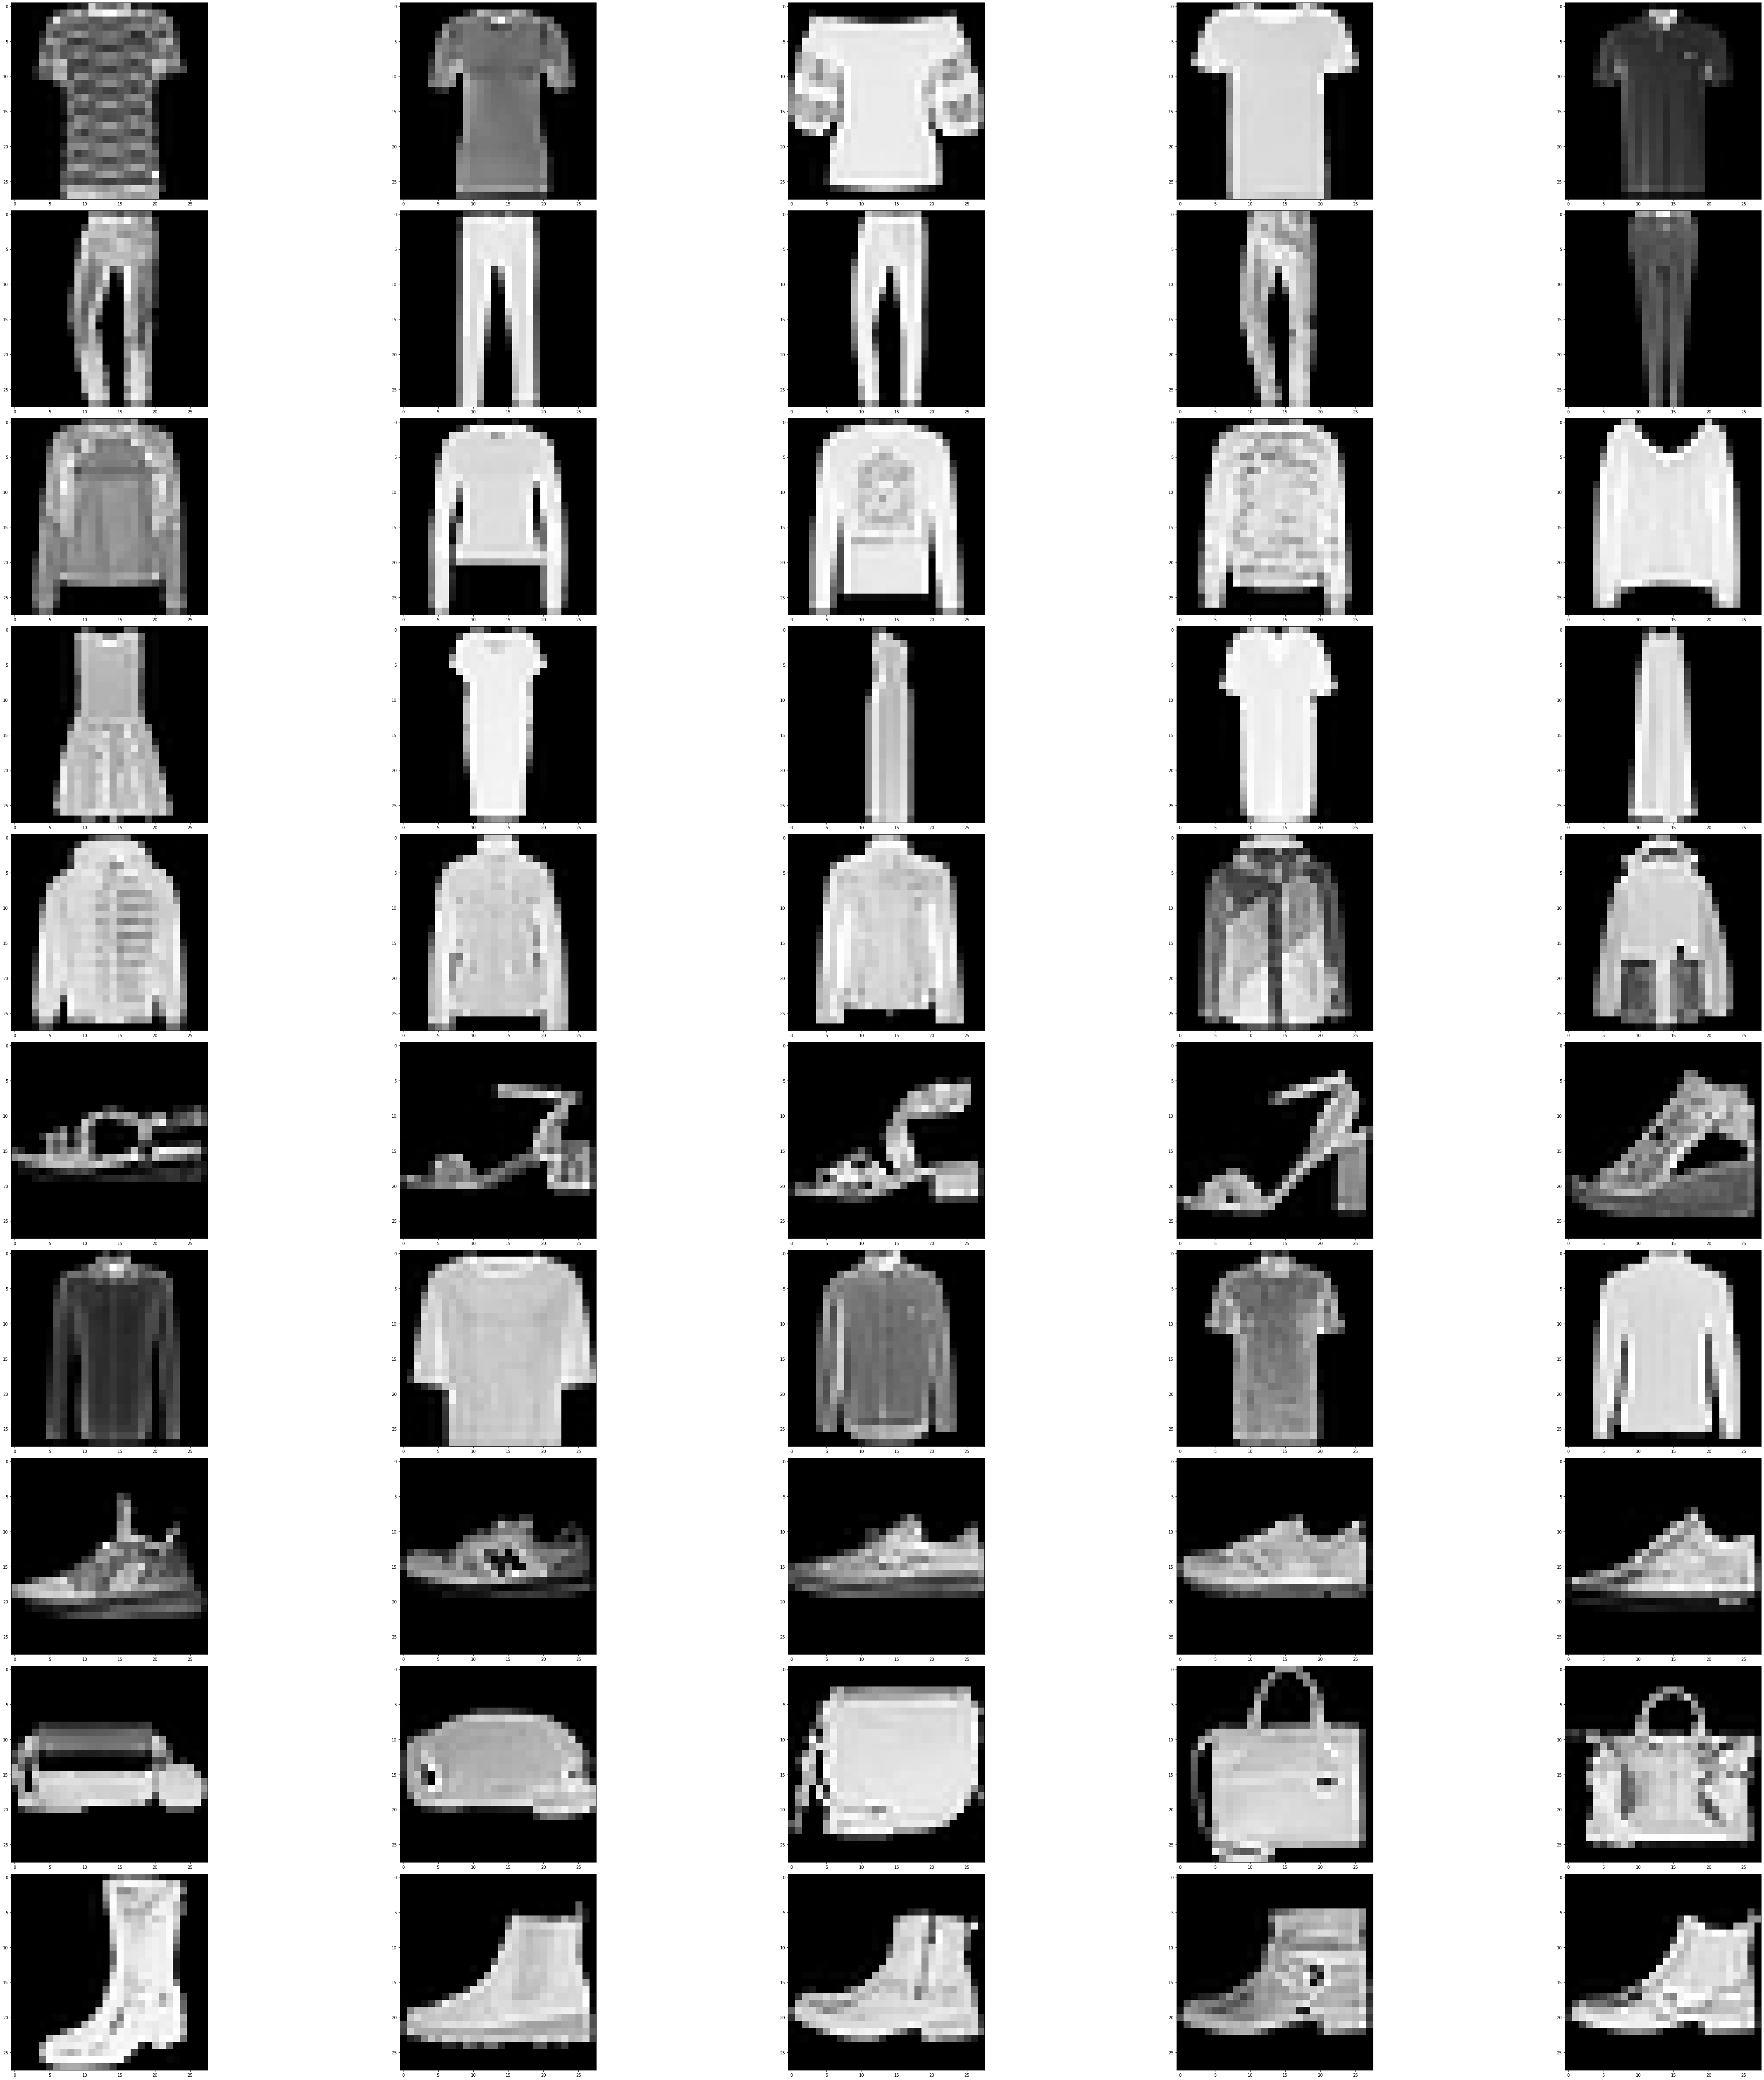

In [ ]:
##Display random images from each class

##Define a function that will display random samples for each class for us
def display_rand_samples(labels,num_samples,imgData_x,imgData_y):
  
  ##Create figure to output images onto
  fig, ax = plt.subplots(len(labels),num_samples,figsize=(70,70))

  ##Loop through labels to display random samples for each label onto subplot
  ct = 0
  for i in labels:
    randomSamples = imgData_x[np.random.choice(np.argwhere(imgData_y==i).flatten(),num_samples)]
    for j in range(num_samples):
      ax[ct,j].imshow(randomSamples[j],cmap='gray')
    ct+=1

  fig.tight_layout()

##Call the function to plot random observations from each super-class (coarse labels)
np.random.seed(1) ##Set random seed so visualization results can be replicated
display_rand_samples(list(np.unique(y_train)),5,x_train,y_train)

So with the results above these images are really interesting and not quite what I expected. I was expecting the dataset to have more realistic looking clothing images. But, we can notice here that its not so much the fine details of each image that matter, but rather the overall shape of the object in the image that gives away what type of fashion object something is. 

Below I am going to display the dimensions of the input images to get a better sense of what they are like at a pixel level:

In [ ]:
##Display dimensions of the training image input
print('Dimensions of Input Image Data:')
x_train[0].shape

Dimensions of Input Image Data:


(28, 28)

So here, we can verify that the images are 28x28x1 Grayscale images. Let's quickly summarize some observations of the random sample images:
* Images don't have granular detail because of their low resolution
  * This indicates to me that an algorithm will find most of its predictive value in being able to recognize how certain fashion items are shaped
  * An algorithm will have a tough time classifying images on factors other than shape like the item material, placement in image, etc 
* Convienently, from this random sample there doesn't appear to be as much intra-class variation as there was in CIFAR-10 or CIFAR-100, potentially making this a less complicated classification problem

With these observations, I have an idea. I believe that a model will gain more classification accuracy by focusing more on the shape of the clothing item than worrying about the variation of grayscale intensity within the image. Therefore, I will attempt 3 image transformations aimed at emphasizing shape information within the training data. I have listed them below:

1. Get rid of all grayscale intensity variation within the clothing object by setting all clothing item pixels to 255 making this essentially a binary image. This transformation might force an algorithm to only pay attention to shape and ignore some confusing grayscale variation noise. 
2. Use contour detection to only keep the contours of each image so that the only information present in an image is the contour of its object. 
3. Use canny edge detection to try and achieve the same property as contour detection. 

Below I will start with eliminating intra-object grayscale intensity variation.

<b>Intra-Object Grayscale Intensity Variation Elimination:</b>

In [ ]:
##Define function that returns an altered image with no intra-object variation
def grayscale_variation(imgArray, newGray_level):

  alteredArray = np.where(np.copy(imgArray) > 5, newGray_level, 0)

  return alteredArray

Now let's create a separate training dataset where we alter each image to undergo this transformation of eliminating intra-object intensity variation. As well, I will create a new test set for this transformation.  

In [ ]:
##Create new dataset that transforms data using methodology

##Create storage location
x_train_intensity = []
x_test_intensity = []

##Alter every image in training set
for i in x_train:
  x_train_intensity.append(grayscale_variation(i,255))
for i in x_test:
  x_test_intensity.append(grayscale_variation(i,255))

##Cast these back as numpy arrays
x_train_intensity = np.array(x_train_intensity)
x_test_intensity = np.array(x_test_intensity)

Now that we've created this new data set, lets re-visualize the same random samples above to view how the information in each information/class has changed. 

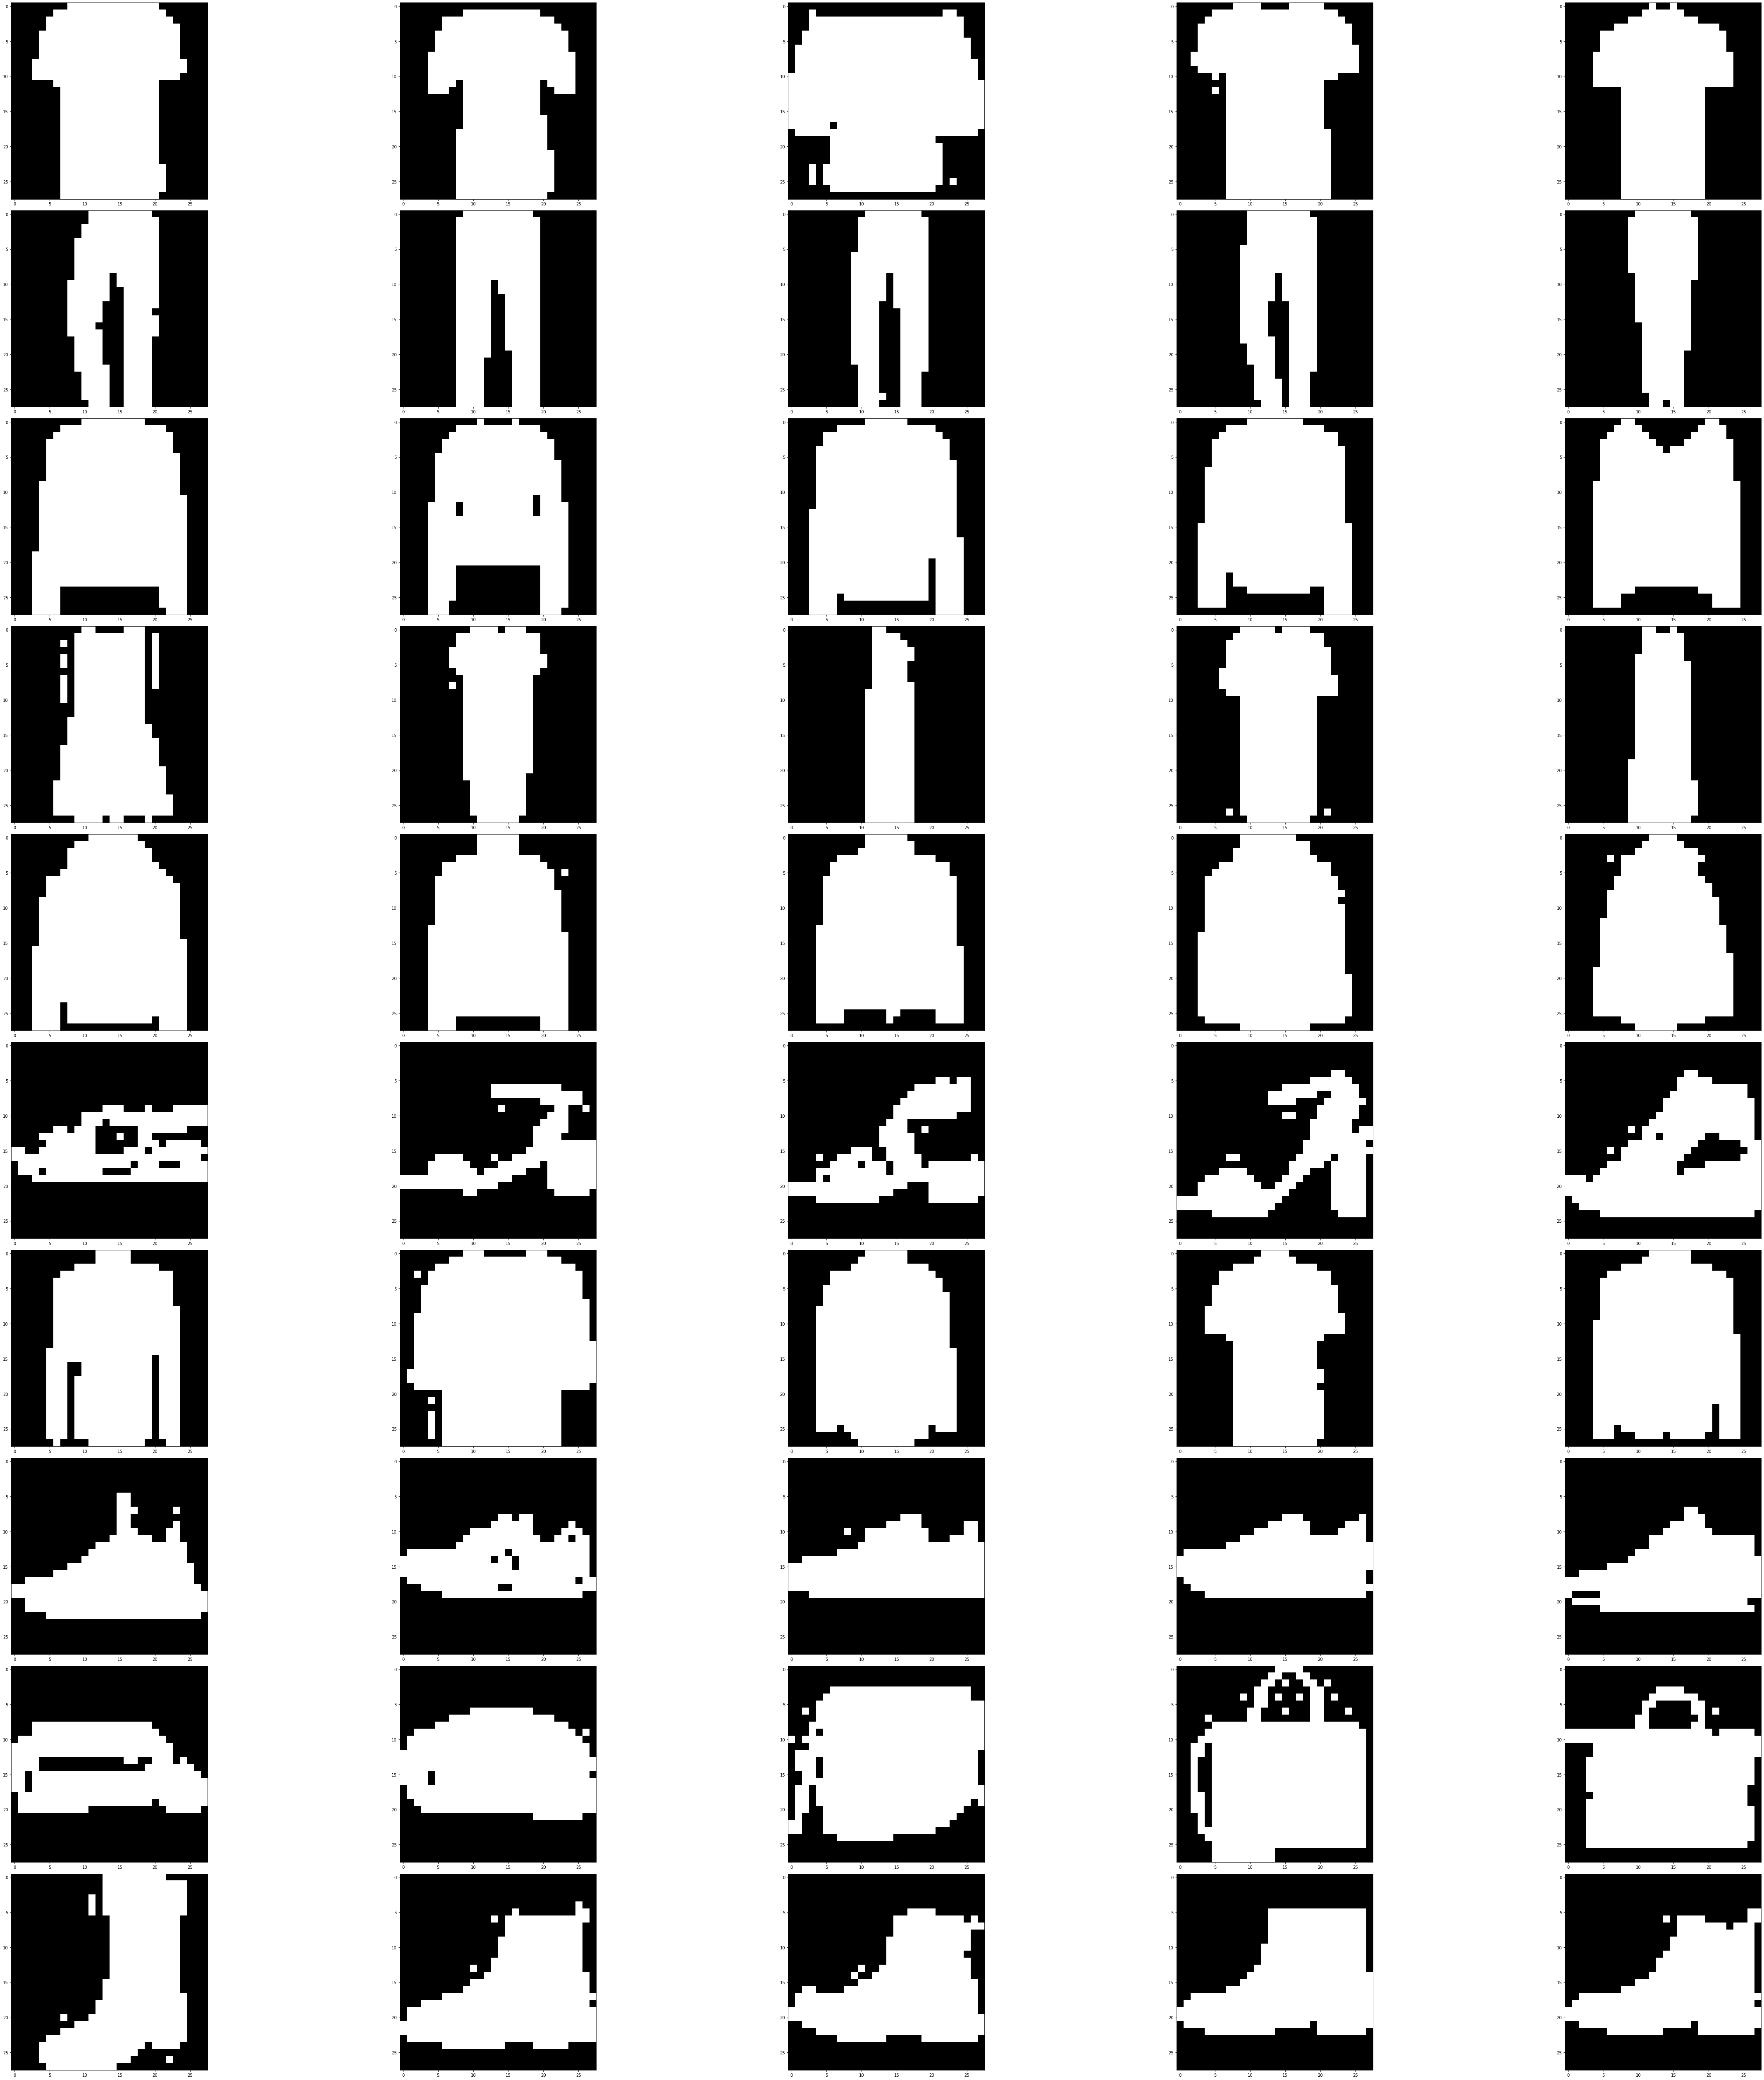

In [ ]:
np.random.seed(1) ##Set random seed so visualization results can be replicated
display_rand_samples(list(np.unique(y_train)),5,x_train_intensity,y_train)

The results above are certainly interesting when comparing the results to the original images. Below I have noted a few observations and how they may help/hurt a classification model's ability to make predictions.

* The classes "Sandal", "Sneaker", and "Boot" appear to be well differentiated from eachother using this methodology to try and focus on shapes
* The bag class benefits from this when there is a handle for the bag, otherwise the shape just looks like a blob
* A pull-over and a coat may be hard to distinguish by getting rid of grayscale variation information within the object itself

Now below I will transform the original images into contour edge images and view the results. 

<b>Image shape through Contour Detection:</b>

Below you'll notice that I've actually decided to perform a pretty interesting type of contour detection method. This method is the Marching Squares Contour algorithm. 

Lets examine how this contour method performs on the data seen above. 

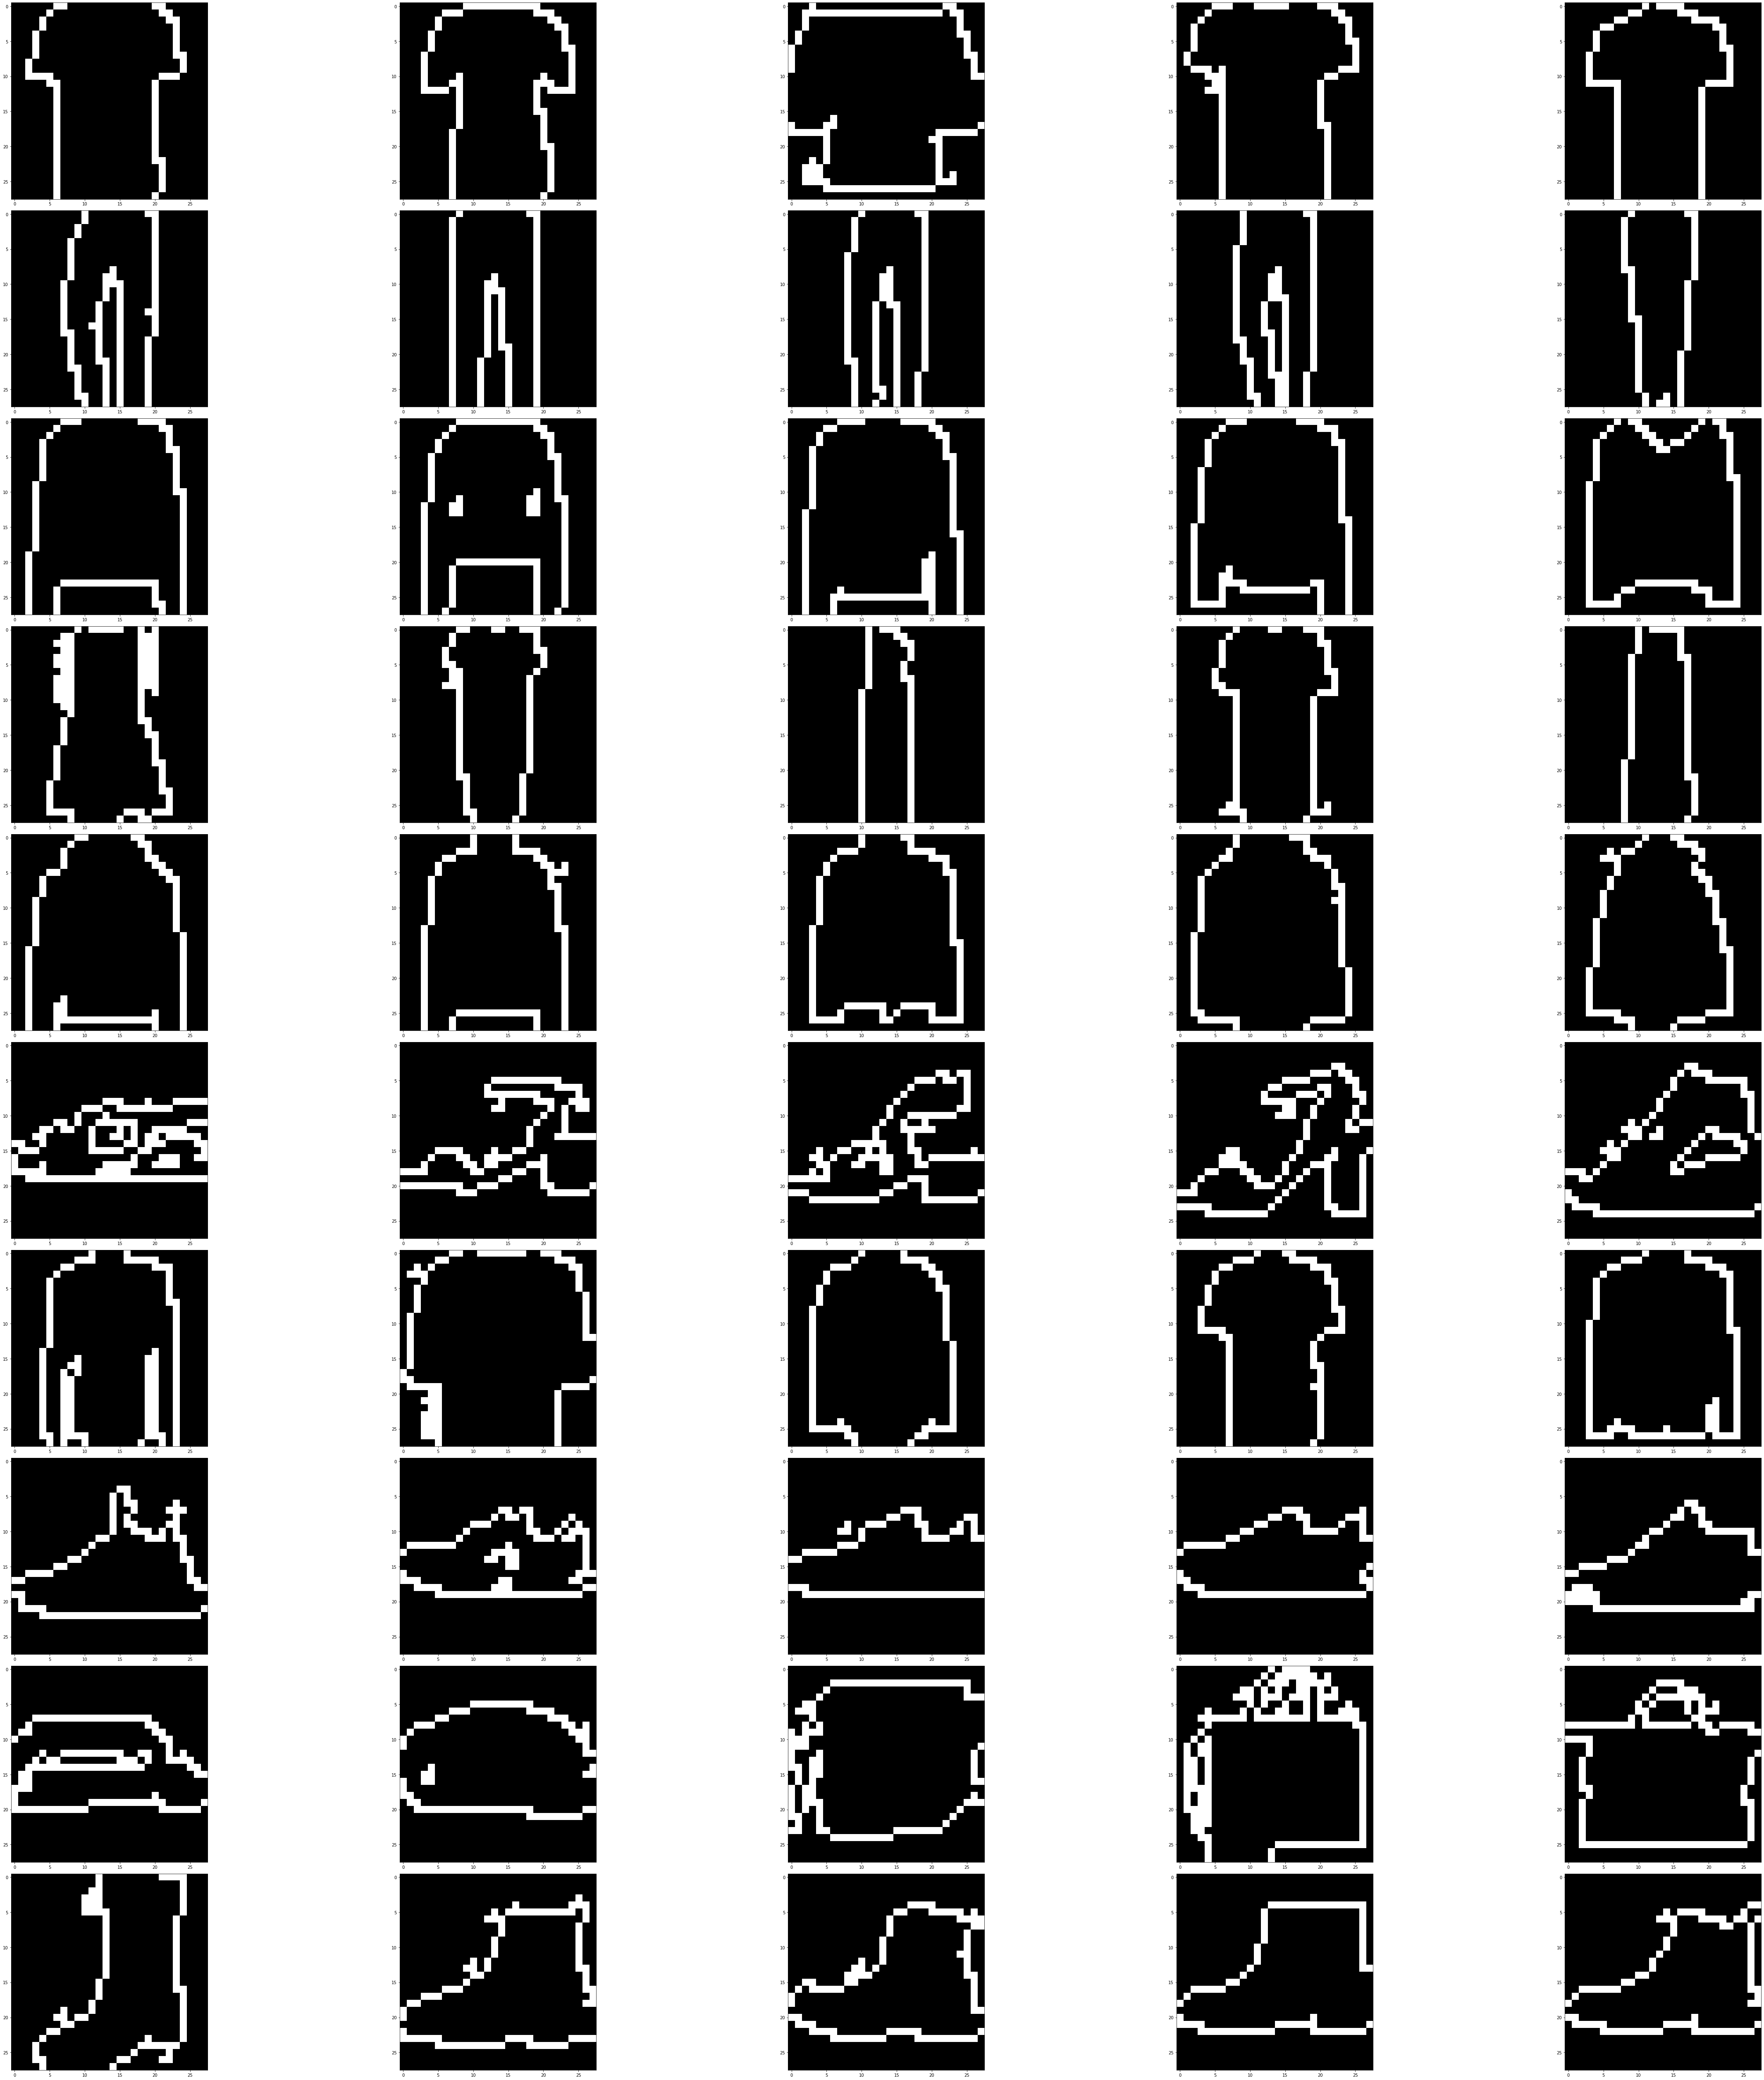

In [ ]:
from skimage import measure

##Create a dataset to visualize the results, but delete it later as it won't be our final contour dataset (this will make sense in a little)
x_train_contour_eda = []
for i in x_train:
  contours = measure.find_contours(i,5)
  x_train_cop = np.copy(i)
  x_train_cop = np.where(x_train_cop>=0,0,0)
  for m in contours:
    for j in m:
      x_train_cop[int(j[0]),int(j[1])] = 255
  x_train_contour_eda.append(x_train_cop.astype(np.uint8))

##Must turn new data into array for indexing
x_train_contour_eda = np.array(x_train_contour_eda)

np.random.seed(1) ##Set random seed so visualization results can be replicated
display_rand_samples(list(np.unique(y_train)),5,x_train_contour_eda,y_train)
##Define the function for contours

##Free up memory by getting rid of this dataset for now
del x_train_contour_eda

In the results above we can see that this method does a pretty good job of getting the contours for each image. 

One of the arguments in the Marching Squares method is "level", which determines how large the grayscale value should be for the method to compute contours. Essentially higher level values lead to more "picky" contours and lower level values lead to less "picky" contours. I will go ahead and visualize what I mean below by plotting out a couple images at different level values. In the graph below the level values are increases from left to right to express what increasing the level does to contours of an image. 

Text(0.5, 0.98, 'Level Value Exploration for Marching Squares Contours')

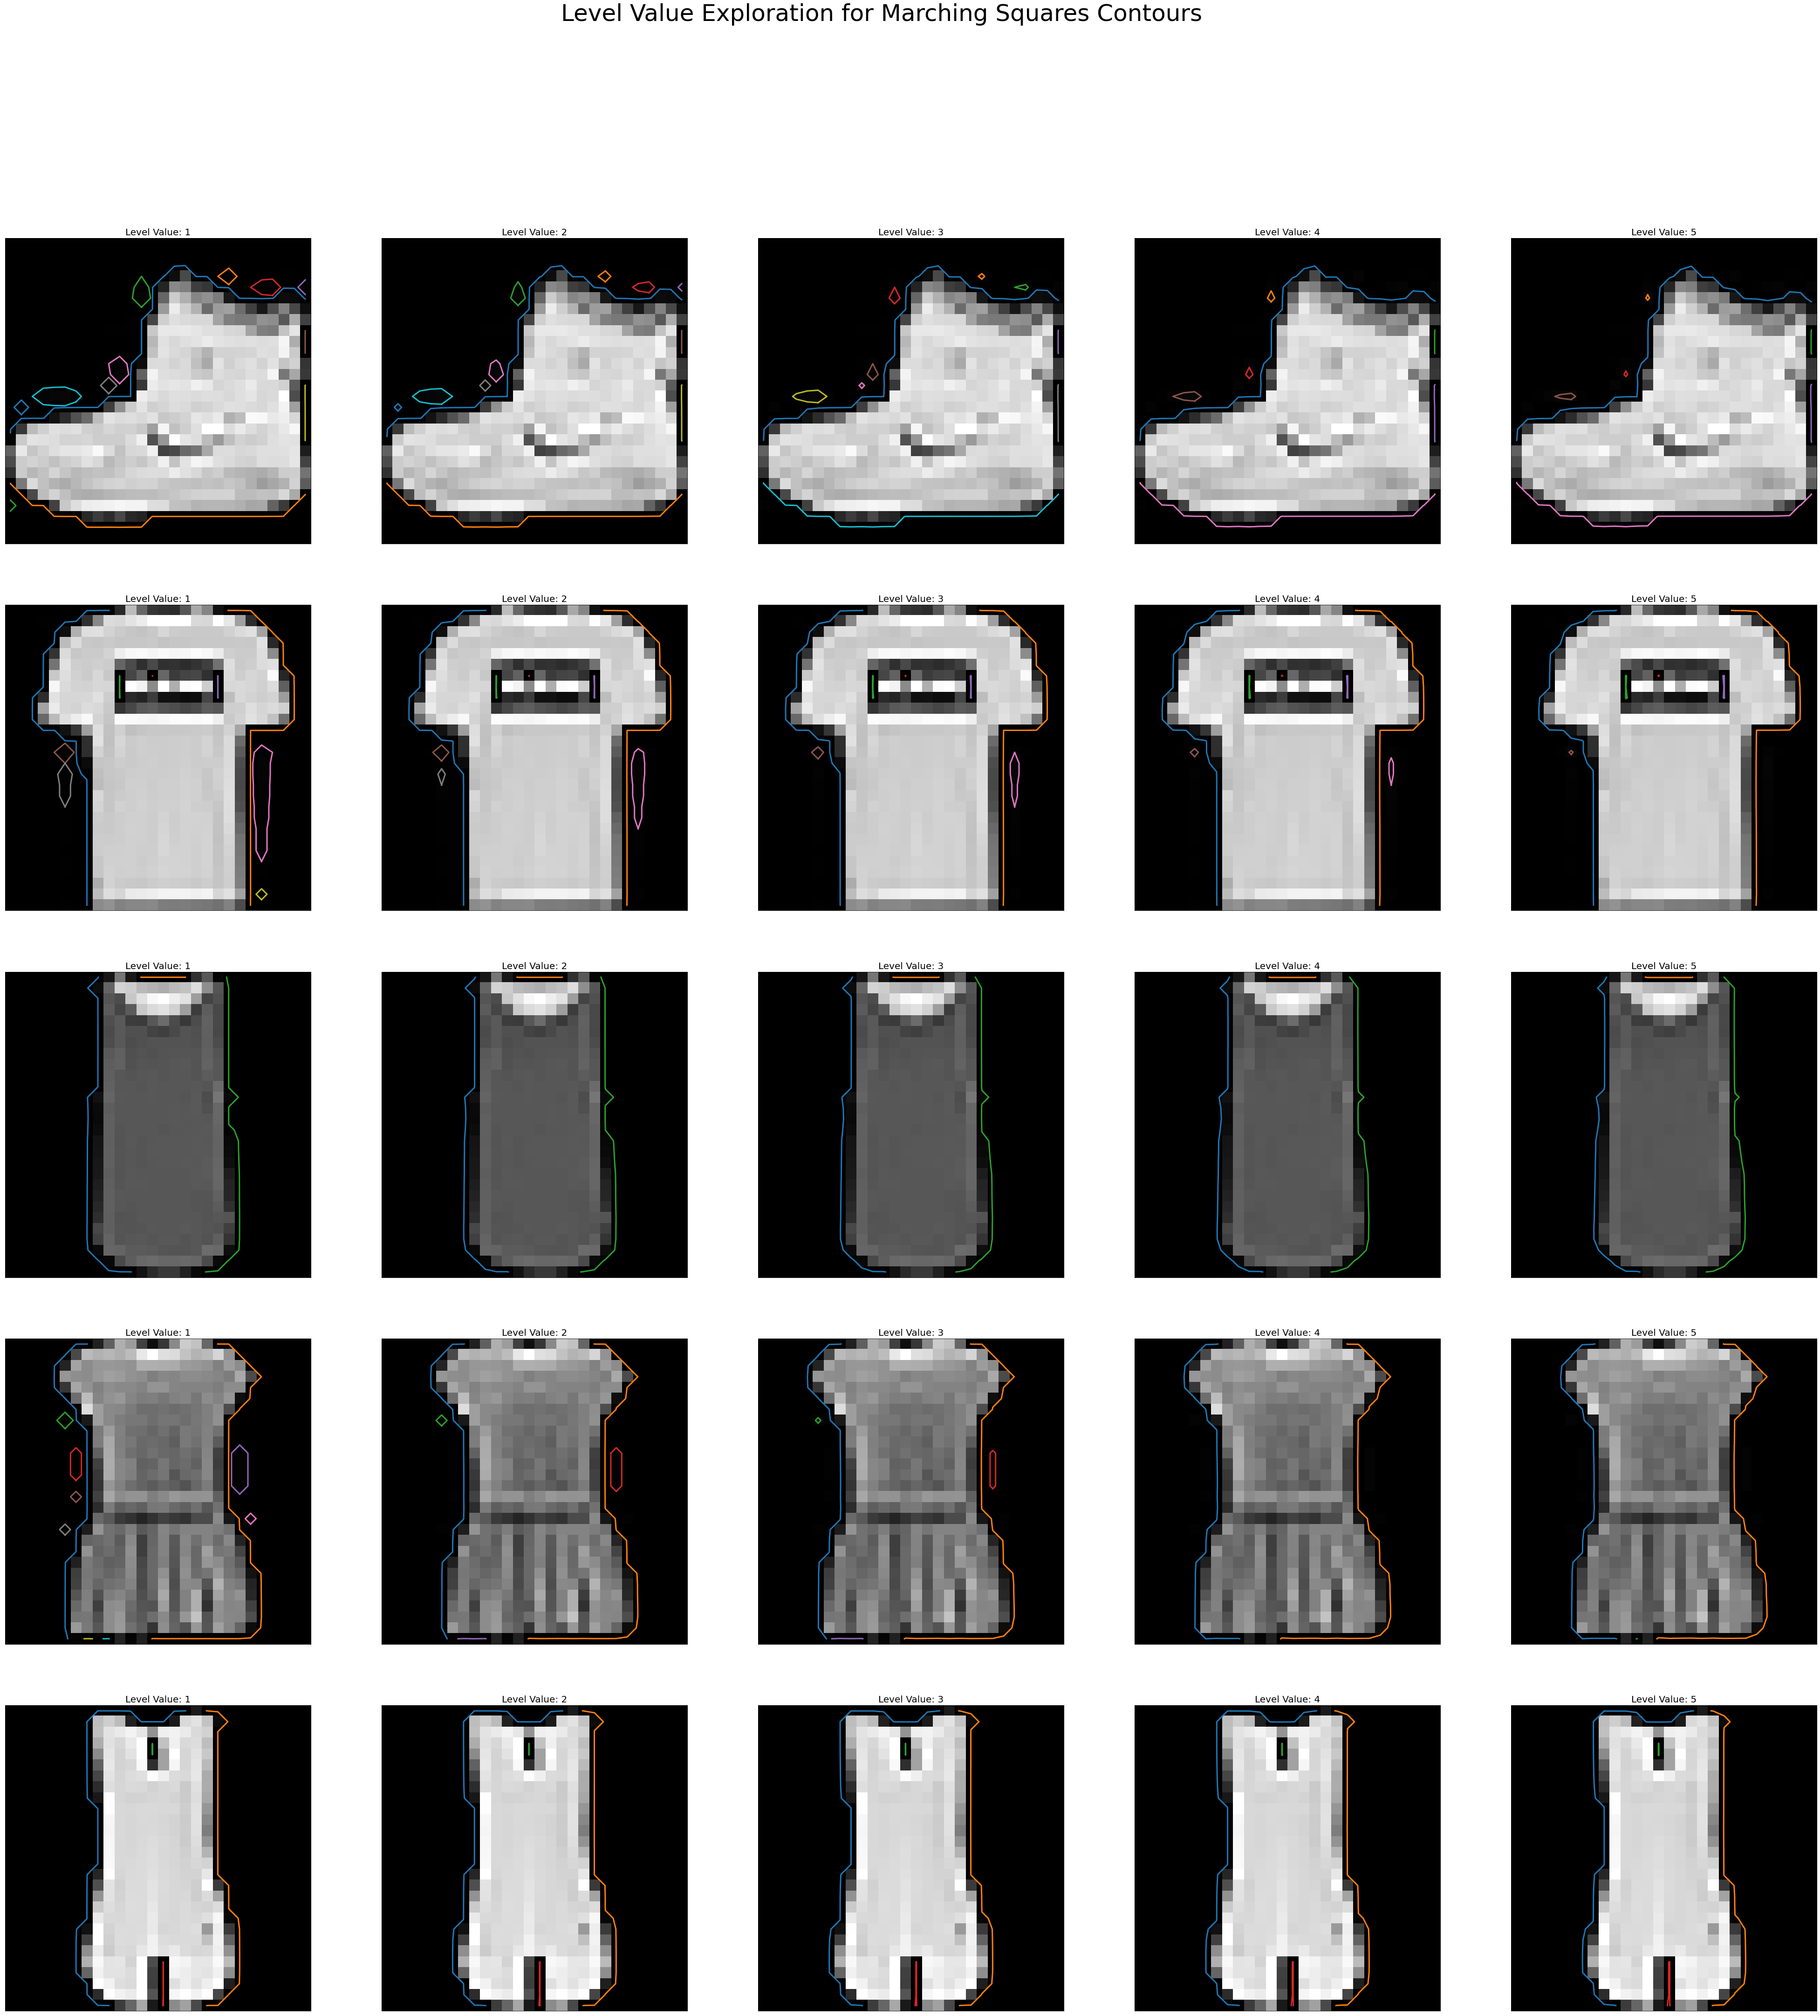

In [ ]:
##Create a subplot for the visualization 
fig, ax = plt.subplots(5,5,figsize=(70,70))

##Plot the contours of different level values
for i in range(5):

  for j in range(5):
      
    ##Compute the contours
    contours = measure.find_contours(x_train[i], j+1)

    # Display the image and plot all contours founds()
    ax[i,j].imshow(x_train[i], cmap=plt.cm.gray)

    for contour in contours:
        ax[i,j].plot(contour[:, 1], contour[:, 0], linewidth=3)

    ax[i,j].axis('image')
    ax[i,j].set_xticks([])
    ax[i,j].set_yticks([])
    ax[i,j].set_title('Level Value: '+str(j+1),size=20)
fig.suptitle('Level Value Exploration for Marching Squares Contours',size=50)

Above we can notice some interesting results about setting the values for "level" in the marching square contour method. Specifically rows 1, 2, and 4 display that setting a lower level value results in additional small contour shapes appearing. The additional contour shapes don't alter the information about the shape of the clothing item itself, but they do add additional noise to the images close to the border of the item. So, I will actually use this Marching Squares method with varying level values as a data augmentation method when training a model on the contours. This should result in being able to make several images out of 1 image and additionally make the model more robust to varying contours it witnesses in the test set. I will keep the test set at a level value of 5 since as can be seen in the plot this value tends to generate the least contour noise. 

Now I will generate the data-augmented training set using this method of varying level values:

In [ ]:
##Define a function that will return a contour image for a certain level
def create_contour(imgArray,level_num):

  ##Get the contours of the image 
  contours = measure.find_contours(imgArray,level=level_num)
  imgContour = np.copy(imgArray)
  imgContour = np.where(imgContour>=0,0,0)

  ##Loop through levels of created contours
  for i in contours:
    for j in i:
      imgContour[int(j[0]),int(j[1])] = 255
  
  ##Return the contoured image
  return imgContour

In [ ]:
##Create augmented dataset for the image (empty storage locations)
x_train_contour = []
y_train_contour = []
x_test_contour = []

##Set a random seed so random level results can be replicated
np.random.seed(1)
for i in range(len(x_train)*2):
  if i > len(x_train)-1:
    i = i-len(x_train)
  x_train_contour.append(create_contour(x_train[i],np.random.uniform(low=0.0, high=5.0, size=1).item()))
  y_train_contour.append(y_train[i].item())
for i in x_test:
  x_test_contour.append(create_contour(i,5))

##Format the new data as numpy arrays
x_train_contour = np.array(x_train_contour)
x_test_contour = np.array(x_test_contour)
y_train_contour = np.array(y_train_contour)

Above I applied the Marching Squares contour method on both the test and training data. I doubled the size of the training data by performing data augmentation by generating two images for every image in the dataset, I did so by randomly selecting a level value uniformly between 0 and 5 and generating the corresponding contour image twice for each image. The test data had its contours created with a constant level value of 5, to introduce less noise. 

<b>Canny Edge Detection:</b>

Open CV actually already has a nice canny edge detector that we can use, so this task is pretty simple. Below I will create a new training and test set that uses canny edge detection for extracting the shape of the image. 

In [ ]:
##Import the corresponding package to perform canny edge detection
import cv2

##Create new train/test sets using canny edge detection
x_train_canny = []
x_test_canny = []

##Transform data using canny edge detection
for i in x_train:
  x_train_canny.append(cv2.Canny(image=np.copy(i), threshold1=100, threshold2=200))
for i in x_test:
  x_test_canny.append(cv2.Canny(image=np.copy(i), threshold1=100, threshold2=200))

##Transform these into numpy arrays
x_train_canny = np.array(x_train_canny)
x_test_canny = np.array(x_test_canny)

Now I would like to plot these results and again compare them to the original versions of themselves plotted above to make assessments about information loss/gain. 

Before I do this it is important to note that Canny edge detection is not only designed to detect edges of the border of a shape, but rather all edges within an image. Because of this, in the results I would expect to see some additional information about the object retained other than just border shape information. 

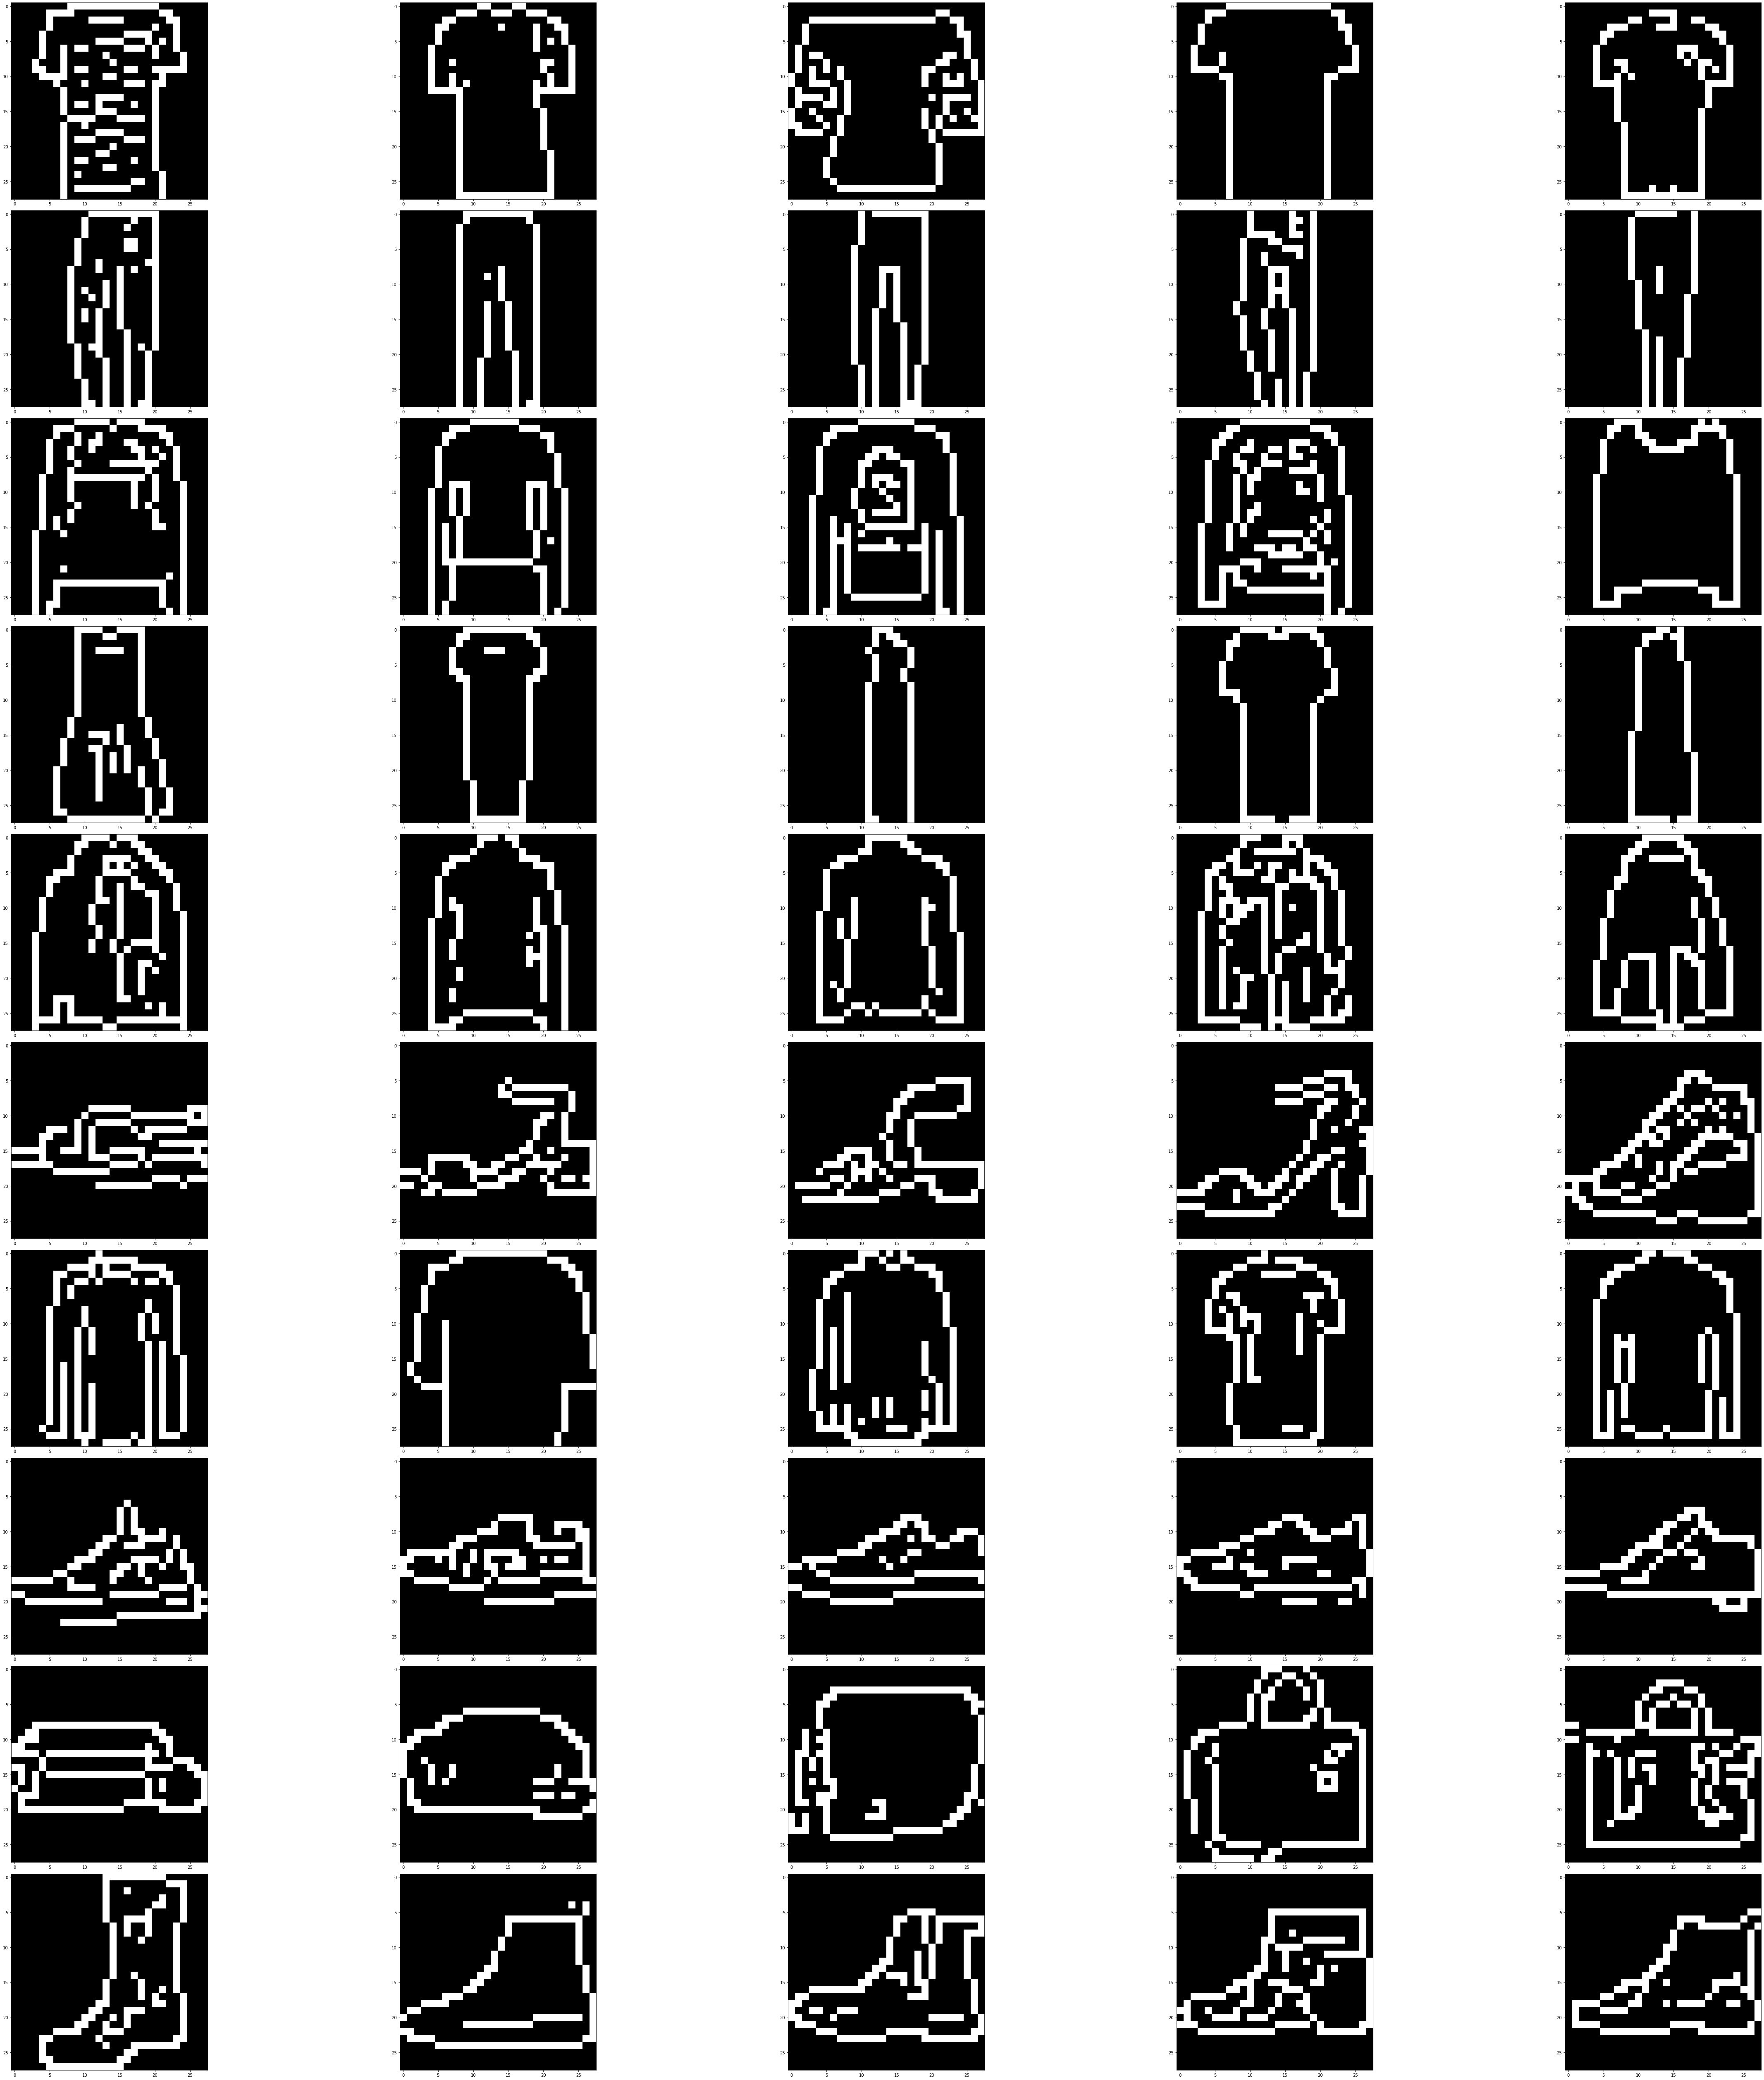

In [ ]:
np.random.seed(1) ##Set random seed so visualization results can be replicated
display_rand_samples(list(np.unique(y_train)),5,x_train_canny,y_train)

I am actually really liking the Canny edge detection results that can be seen above, moreso than the other two transformations. By collecting information on all edges of the image rather than just the contour, we still retain some useful information about properties within the object. Also, by using edge detection these images could have an advantage over the original dataset in that it reduces some noise that could be present because of the grayscale variation within the object in the image. 

Here are some additional observations:
* In row 5 resides the "coat" class, canny edge detection pronounces features of the coats like zippers or bagginess which can help better differentiate it from the "shirt" class in row 7
* Canny edge detection pronounces where the sole of footwear is in the images for the classes "sneaker" and "ankle boot"
* For the "Bag" class, canny edge detection preserves more inner-object bag features then the elimination of grayscale variation or contour detection did, perhaps we will see an increase in accuracy for this class using this data

<b>Build the Image Models:</b>

Now I will build a nueral network that trains on each of these different datasets to determine if my hypothesis of shape importance is at all correct. It is entirely possible that by focusing on shape, we took too much information away from the original images and that in fact training a model on the original images will be more robust.

A note is that in my previous bi-weekly report, I found that I actually really prefer building models using class definitions as opposed to the simpler keras sequential model. This is because it allows for more flexibility with customization of the model architecture and is good for trying out new ideas like min-max normalization instead of batch normalization (Performed in my last bi-weekly report).

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, GlobalAveragePooling2D, Dropout

##Create class for a model (considered more "expert" on tensorflow site)
class FashionModel(Model):
    
    def __init__(self):
        
        super(FashionModel, self).__init__()
        self.conv1 = Conv2D(28,(1,1),activation='relu',input_shape=(28,28,1))
        self.batch1 = BatchNormalization()
        
        self.conv2 = Conv2D(64,(3,3),activation='relu')
        self.batch2 = BatchNormalization()
        
        self.conv3 = Conv2D(128,(3,3),activation='relu')
        self.batch3 = BatchNormalization()
        
        self.globAvgPool = GlobalAveragePooling2D() ##Aids in regularization
        
        self.d1 = Dense(128, activation='relu')
        self.drop = Dropout(.5)
        self.d2 = Dense(20, activation='softmax')
        
    def call(self, x):
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.conv2(x)
        x = self.batch2(x)
        x = self.conv3(x)
        x = self.batch3(x)
        x = self.globAvgPool(x)
        x = self.d1(x)
        x = self.drop(x)
        return self.d2(x)

<b>Generate and train the model for Intra-Object Gray-Scale Variation:</b>

In [ ]:
##Create an instance of the model that will be used for grayscale variation
variationModel = FashionModel()

In [ ]:
##Conduct a step of data normalization
x_train_intensity, x_test_intensity = x_train_intensity / 255.0, x_test_intensity / 255.0

##Perform train/validation split on the data
from sklearn.model_selection import train_test_split
x_train_intensity, x_val_intensity, y_train_intensity, y_val = train_test_split(x_train_intensity, y_train, test_size=0.25, random_state=42)

##Re-shape the data so that is it comptabile with the model
x_train_intensity = x_train_intensity.reshape(-1, 28, 28, 1)
x_val_intensity = x_val_intensity.reshape(-1, 28, 28, 1)

In [ ]:
##Compile the model
variationModel.compile(optimizer='adam',
                             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                             metrics=['accuracy'])

##Fit the model
variation_fit = variationModel.fit(x_train_intensity, y_train_intensity, 
                                          batch_size=32, epochs=50, validation_data=(x_val_intensity, y_val),verbose=2)

Epoch 1/50
1407/1407 - 47s - loss: 0.8503 - accuracy: 0.6889 - val_loss: 2.0378 - val_accuracy: 0.4503
Epoch 2/50
1407/1407 - 16s - loss: 0.5907 - accuracy: 0.7858 - val_loss: 0.5112 - val_accuracy: 0.8133
Epoch 3/50
1407/1407 - 16s - loss: 0.5191 - accuracy: 0.8110 - val_loss: 0.5927 - val_accuracy: 0.7789
Epoch 4/50
1407/1407 - 16s - loss: 0.4801 - accuracy: 0.8239 - val_loss: 0.4499 - val_accuracy: 0.8296
Epoch 5/50
1407/1407 - 16s - loss: 0.4538 - accuracy: 0.8335 - val_loss: 0.4204 - val_accuracy: 0.8426
Epoch 6/50
1407/1407 - 17s - loss: 0.4382 - accuracy: 0.8397 - val_loss: 0.3943 - val_accuracy: 0.8531
Epoch 7/50
1407/1407 - 16s - loss: 0.4222 - accuracy: 0.8436 - val_loss: 0.3803 - val_accuracy: 0.8579
Epoch 8/50
1407/1407 - 16s - loss: 0.4123 - accuracy: 0.8481 - val_loss: 0.4004 - val_accuracy: 0.8532
Epoch 9/50
1407/1407 - 16s - loss: 0.4029 - accuracy: 0.8496 - val_loss: 0.3731 - val_accuracy: 0.8639
Epoch 10/50
1407/1407 - 16s - loss: 0.3972 - accuracy: 0.8544 - val_loss:

Now lets assess the test accuracy of this method:

In [ ]:
##Reshape the test data
x_test_intensity = x_test_intensity.reshape(-1, 28, 28, 1)

##Evaluate the testing accuracy of the model
print('Test Accuracy of Intensity Variation Elimination Model:')
variationModel.evaluate(x_test_intensity,  y_test, verbose=0)[1]

Test Accuracy of Intensity Variation Elimination Model:


0.8659999966621399

Viewing the test accuracy results above of 86.6%, I am very happy to see that there was essentially no over-fitting of the model. The validation accuracy was 87.07% and the training was 88.78% in the last epoch, which doesn't seem high enough to say there was any noticeable over-fitting when moving to the test data. Clearly training this model on the transformed data from the Gray-scale variation elimination method created above was somewhat effective at giving the model a good input to train on. I am actually somewhat surprised by these results as it was my least favorite transformation out of the three attempted based on EDA above. I thought this method would get rid of too much information of the inside of a fashion object only resulting in shape information being preserved. I'm now eager to see if the Contour or Canny Edge detection methods worked better given I slightly preferred those from the results I saw in the EDA portion of the notebook. 

<b>Generate and train model for Contour Edges:</b>

In [ ]:
##Create an instance of the model that will be used for contours
contourModel = FashionModel()

In [ ]:
##Conduct a step of data normalization
x_train_contour, x_test_contour = x_train_contour / 255.0, x_test_contour / 255.0

##Perform train/validation split on the data
from sklearn.model_selection import train_test_split
x_train_contour, x_val_contour, y_train_contour, y_val = train_test_split(x_train_contour, y_train_contour, test_size=0.25, random_state=42)

##Re-shape the data so that is it comptabile with the model
x_train_contour = x_train_contour.reshape(-1, 28, 28, 1)
x_val_contour = x_val_contour.reshape(-1, 28, 28, 1)

In [ ]:
##Compile the model
contourModel.compile(optimizer='adam',
                             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                             metrics=['accuracy'])

##Fit the model
contour_fit = contourModel.fit(x_train_contour, y_train_contour, 
                                          batch_size=32, epochs=50, validation_data=(x_val_contour, y_val),verbose=2)

Epoch 1/50
2813/2813 - 33s - loss: 0.7941 - accuracy: 0.7135 - val_loss: 0.5542 - val_accuracy: 0.8016
Epoch 2/50
2813/2813 - 33s - loss: 0.5682 - accuracy: 0.7963 - val_loss: 0.5170 - val_accuracy: 0.8112
Epoch 3/50
2813/2813 - 32s - loss: 0.5135 - accuracy: 0.8144 - val_loss: 0.4857 - val_accuracy: 0.8134
Epoch 4/50
2813/2813 - 32s - loss: 0.4826 - accuracy: 0.8254 - val_loss: 0.4362 - val_accuracy: 0.8373
Epoch 5/50
2813/2813 - 32s - loss: 0.4647 - accuracy: 0.8300 - val_loss: 0.4696 - val_accuracy: 0.8244
Epoch 6/50
2813/2813 - 32s - loss: 0.4497 - accuracy: 0.8362 - val_loss: 0.3950 - val_accuracy: 0.8521
Epoch 7/50
2813/2813 - 32s - loss: 0.4335 - accuracy: 0.8422 - val_loss: 0.3866 - val_accuracy: 0.8569
Epoch 8/50
2813/2813 - 32s - loss: 0.4256 - accuracy: 0.8449 - val_loss: 0.3770 - val_accuracy: 0.8562
Epoch 9/50
2813/2813 - 32s - loss: 0.4163 - accuracy: 0.8468 - val_loss: 0.4193 - val_accuracy: 0.8444
Epoch 10/50
2813/2813 - 33s - loss: 0.4071 - accuracy: 0.8498 - val_loss:

Now lets see how the model performs on test data again:

In [ ]:
##Reshape the test data
x_test_contour = x_test_contour.reshape(-1, 28, 28, 1)

##Evaluate the testing accuracy of the model
print('Test Accuracy of Marching Squares Contour Model:')
contourModel.evaluate(x_test_contour,  y_test, verbose=0)[1]

Test Accuracy of Marching Squares Contour Model:


0.8463000059127808

So the test results for the Marching Squares Contour transformed data actually went down in comparison to the grayscale variation elimination model. I was expecting this model to be more robust since I performed data augmentation by varying the marching squares level value on the training data to double the size of the dataset. However, it has a test accuracy of 84.63% which is a slight decrease. One positive note is that there is not a significant drop in accuracy from training to test indicating the model is still relatively robust. 

<b>Generate and train model for Canny Edge Detection:</b>

In [ ]:
##Create an instance of the model that will be used for canny edge detection
cannyModel = FashionModel()

In [ ]:
##Conduct a step of data normalization
x_train_canny, x_test_canny = x_train_canny / 255.0, x_test_canny / 255.0

##Perform train/validation split on the data
from sklearn.model_selection import train_test_split
x_train_canny, x_val_canny, y_train_canny, y_val = train_test_split(x_train_canny, y_train, test_size=0.25, random_state=42)

##Re-shape the data so that is it comptabile with the model
x_train_canny = x_train_canny.reshape(-1, 28, 28, 1)
x_val_canny = x_val_canny.reshape(-1, 28, 28, 1)

In [ ]:
##Compile the model
cannyModel.compile(optimizer='adam',
                             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                             metrics=['accuracy'])

##Fit the model
canny_fit = cannyModel.fit(x_train_canny, y_train_canny, 
                                          batch_size=32, epochs=50, validation_data=(x_val_canny, y_val),verbose=2)

Epoch 1/50
1407/1407 - 17s - loss: 1.0368 - accuracy: 0.6284 - val_loss: 0.8527 - val_accuracy: 0.6823
Epoch 2/50
1407/1407 - 16s - loss: 0.7569 - accuracy: 0.7288 - val_loss: 0.6502 - val_accuracy: 0.7624
Epoch 3/50
1407/1407 - 16s - loss: 0.6692 - accuracy: 0.7611 - val_loss: 0.6203 - val_accuracy: 0.7781
Epoch 4/50
1407/1407 - 16s - loss: 0.6167 - accuracy: 0.7804 - val_loss: 0.5914 - val_accuracy: 0.7783
Epoch 5/50
1407/1407 - 16s - loss: 0.5832 - accuracy: 0.7904 - val_loss: 0.5508 - val_accuracy: 0.8009
Epoch 6/50
1407/1407 - 16s - loss: 0.5533 - accuracy: 0.8006 - val_loss: 0.5433 - val_accuracy: 0.7969
Epoch 7/50
1407/1407 - 16s - loss: 0.5321 - accuracy: 0.8080 - val_loss: 0.5018 - val_accuracy: 0.8139
Epoch 8/50
1407/1407 - 16s - loss: 0.5206 - accuracy: 0.8121 - val_loss: 0.5065 - val_accuracy: 0.8145
Epoch 9/50
1407/1407 - 16s - loss: 0.5034 - accuracy: 0.8175 - val_loss: 0.4687 - val_accuracy: 0.8265
Epoch 10/50
1407/1407 - 16s - loss: 0.4887 - accuracy: 0.8224 - val_loss:

Now for the Canny model let's assess it's test performance:

In [ ]:
##Reshape the test data
x_test_canny = x_test_canny.reshape(-1, 28, 28, 1)

##Evaluate the testing accuracy of the model
print('Test Accuracy of Canny Edge Detection Model:')
cannyModel.evaluate(x_test_canny,  y_test, verbose=0)[1]

Test Accuracy of Canny Edge Detection Model:


0.8098999857902527

The Canny Edge Detection model sees lower accuracy and a little more over-fitting than the previous two transformation methods. We see that the training accuracy in the last epoch is 89.73% while the test accuracy is 80.99%. Unlike the other two transformations, Canny Edge detection preserved more detail on the inside of fashion objects, not just the shape of the object. This might have allowed the algorithm to memorize these details while training which led to over-fitting. 

<b>Generate and train model using regular images:</b>

In [ ]:
##Create an instance of the model that will be used for regular images
regularModel = FashionModel()

In [ ]:
##Conduct a step of data normalization
x_train_regular, x_test_regular = x_train / 255.0, x_test / 255.0

##Perform train/validation split on the data
from sklearn.model_selection import train_test_split
x_train_regular, x_val_regular, y_train_regular, y_val = train_test_split(x_train_regular, y_train, test_size=0.25, random_state=42)

##Re-shape the data so that is it comptabile with the model
x_train_regular = x_train_regular.reshape(-1, 28, 28, 1)
x_val_regular = x_val_regular.reshape(-1, 28, 28, 1)

In [ ]:
##Compile the model
regularModel.compile(optimizer='adam',
                             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                             metrics=['accuracy'])

##Fit the model
regular_fit = regularModel.fit(x_train_regular, y_train_regular, 
                                          batch_size=32, epochs=50, validation_data=(x_val_regular, y_val),verbose=2)

Epoch 1/50
1407/1407 - 17s - loss: 0.8687 - accuracy: 0.6849 - val_loss: 0.8688 - val_accuracy: 0.6850
Epoch 2/50
1407/1407 - 16s - loss: 0.5683 - accuracy: 0.7963 - val_loss: 0.5115 - val_accuracy: 0.8133
Epoch 3/50
1407/1407 - 16s - loss: 0.4791 - accuracy: 0.8267 - val_loss: 0.8291 - val_accuracy: 0.7198
Epoch 4/50
1407/1407 - 16s - loss: 0.4223 - accuracy: 0.8486 - val_loss: 0.4011 - val_accuracy: 0.8568
Epoch 5/50
1407/1407 - 16s - loss: 0.3940 - accuracy: 0.8588 - val_loss: 0.4215 - val_accuracy: 0.8481
Epoch 6/50
1407/1407 - 17s - loss: 0.3716 - accuracy: 0.8662 - val_loss: 0.4024 - val_accuracy: 0.8473
Epoch 7/50
1407/1407 - 16s - loss: 0.3533 - accuracy: 0.8740 - val_loss: 0.3362 - val_accuracy: 0.8749
Epoch 8/50
1407/1407 - 16s - loss: 0.3397 - accuracy: 0.8774 - val_loss: 0.3798 - val_accuracy: 0.8638
Epoch 9/50
1407/1407 - 16s - loss: 0.3249 - accuracy: 0.8828 - val_loss: 0.3392 - val_accuracy: 0.8762
Epoch 10/50
1407/1407 - 17s - loss: 0.3174 - accuracy: 0.8848 - val_loss:

Now lets finally get the accuracy of a model trained on the Fashion MNIST dataset with no data transformations applied:

In [ ]:
##Reshape the test data
x_test_regular = x_test_regular.reshape(-1, 28, 28, 1)

##Evaluate the testing accuracy of the model
print('Test Accuracy of Regular Data Model:')
regularModel.evaluate(x_test_regular,  y_test, verbose=0)[1]

Test Accuracy of Regular Data Model:


0.9021000266075134

Training a model on the un-altered Fashion MNIST dataset actually worked out the best. There was no over-fitting moving from the validation to the test with an accuracy of 90.21%. My hypothesis is that in the transformations I performed where I was trying to emphasize shape is that I took away too much granular information about the fashion object itself, preventing the network from learning enough about the data to generalize as good as just using the original data. 

<b>Image Ensemble:</b>

Now that I have created and assessed the results of a single model for each image transformation, and compared those results to a model trained on the original images, I would like to ensemble the regular images and transformed images all into one model. As is visually displayed below, essentially the original image and all three transformations of that image will be stacked on top of eachother to create a final 4 channel image to use as input to attempt and increase robustness.

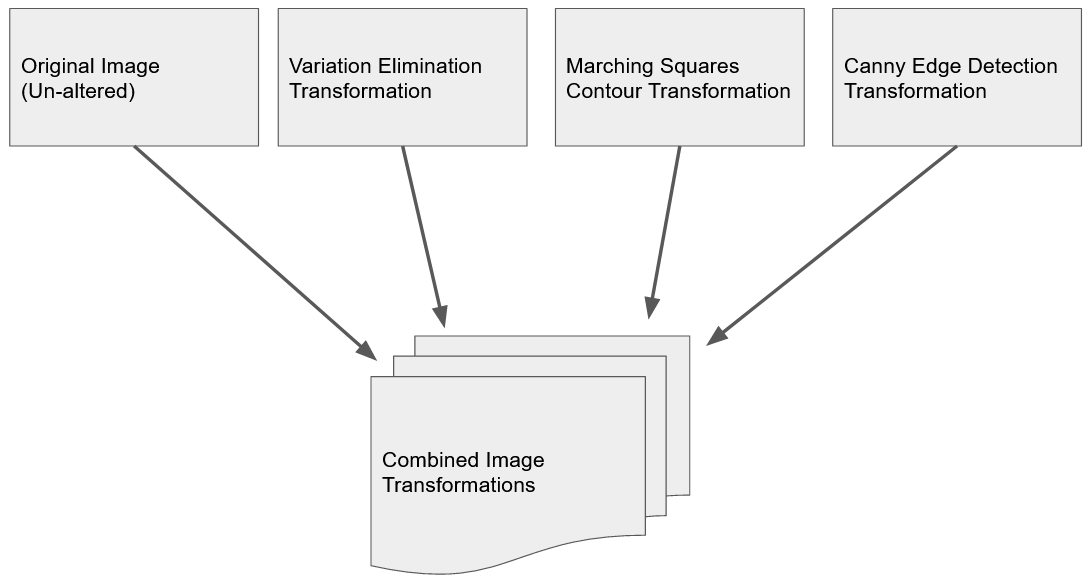



Below I will start by defining a function that performs the stacking operation to make new input images:

In [ ]:
##Define function to stack an image with all its transformations
def stack_images(imgArray):

  ##Create the grayscale variation elimination image
  variationImg = grayscale_variation(imgArray,255)

  ##Create the contour image use a level of 3
  contourImg = create_contour(imgArray,3)

  ##Create the canny image
  cannyImg = cv2.Canny(image=np.copy(i), threshold1=100, threshold2=200)

  ##Combine all into one image
  stackedImg = np.dstack((imgArray,variationImg,contourImg,cannyImg))

  return stackedImg

Now create a new training and test set that stacks the original image and its transformations together so that we can make a model based off this new data:

In [ ]:
##Create new training and test set
x_train_stack = []
x_test_stack = []

##Perform operations on images
for i in x_train:
  x_train_stack.append(stack_images(i))
for i in x_test:
  x_test_stack.append(stack_images(i))

##Format these as numpy arrays
x_train_stack = np.array(x_train_stack)
x_test_stack = np.array(x_test_stack)

Now, it might not mean much visually, but lets at least plot these stacked images to see what we are inputting into the network. 

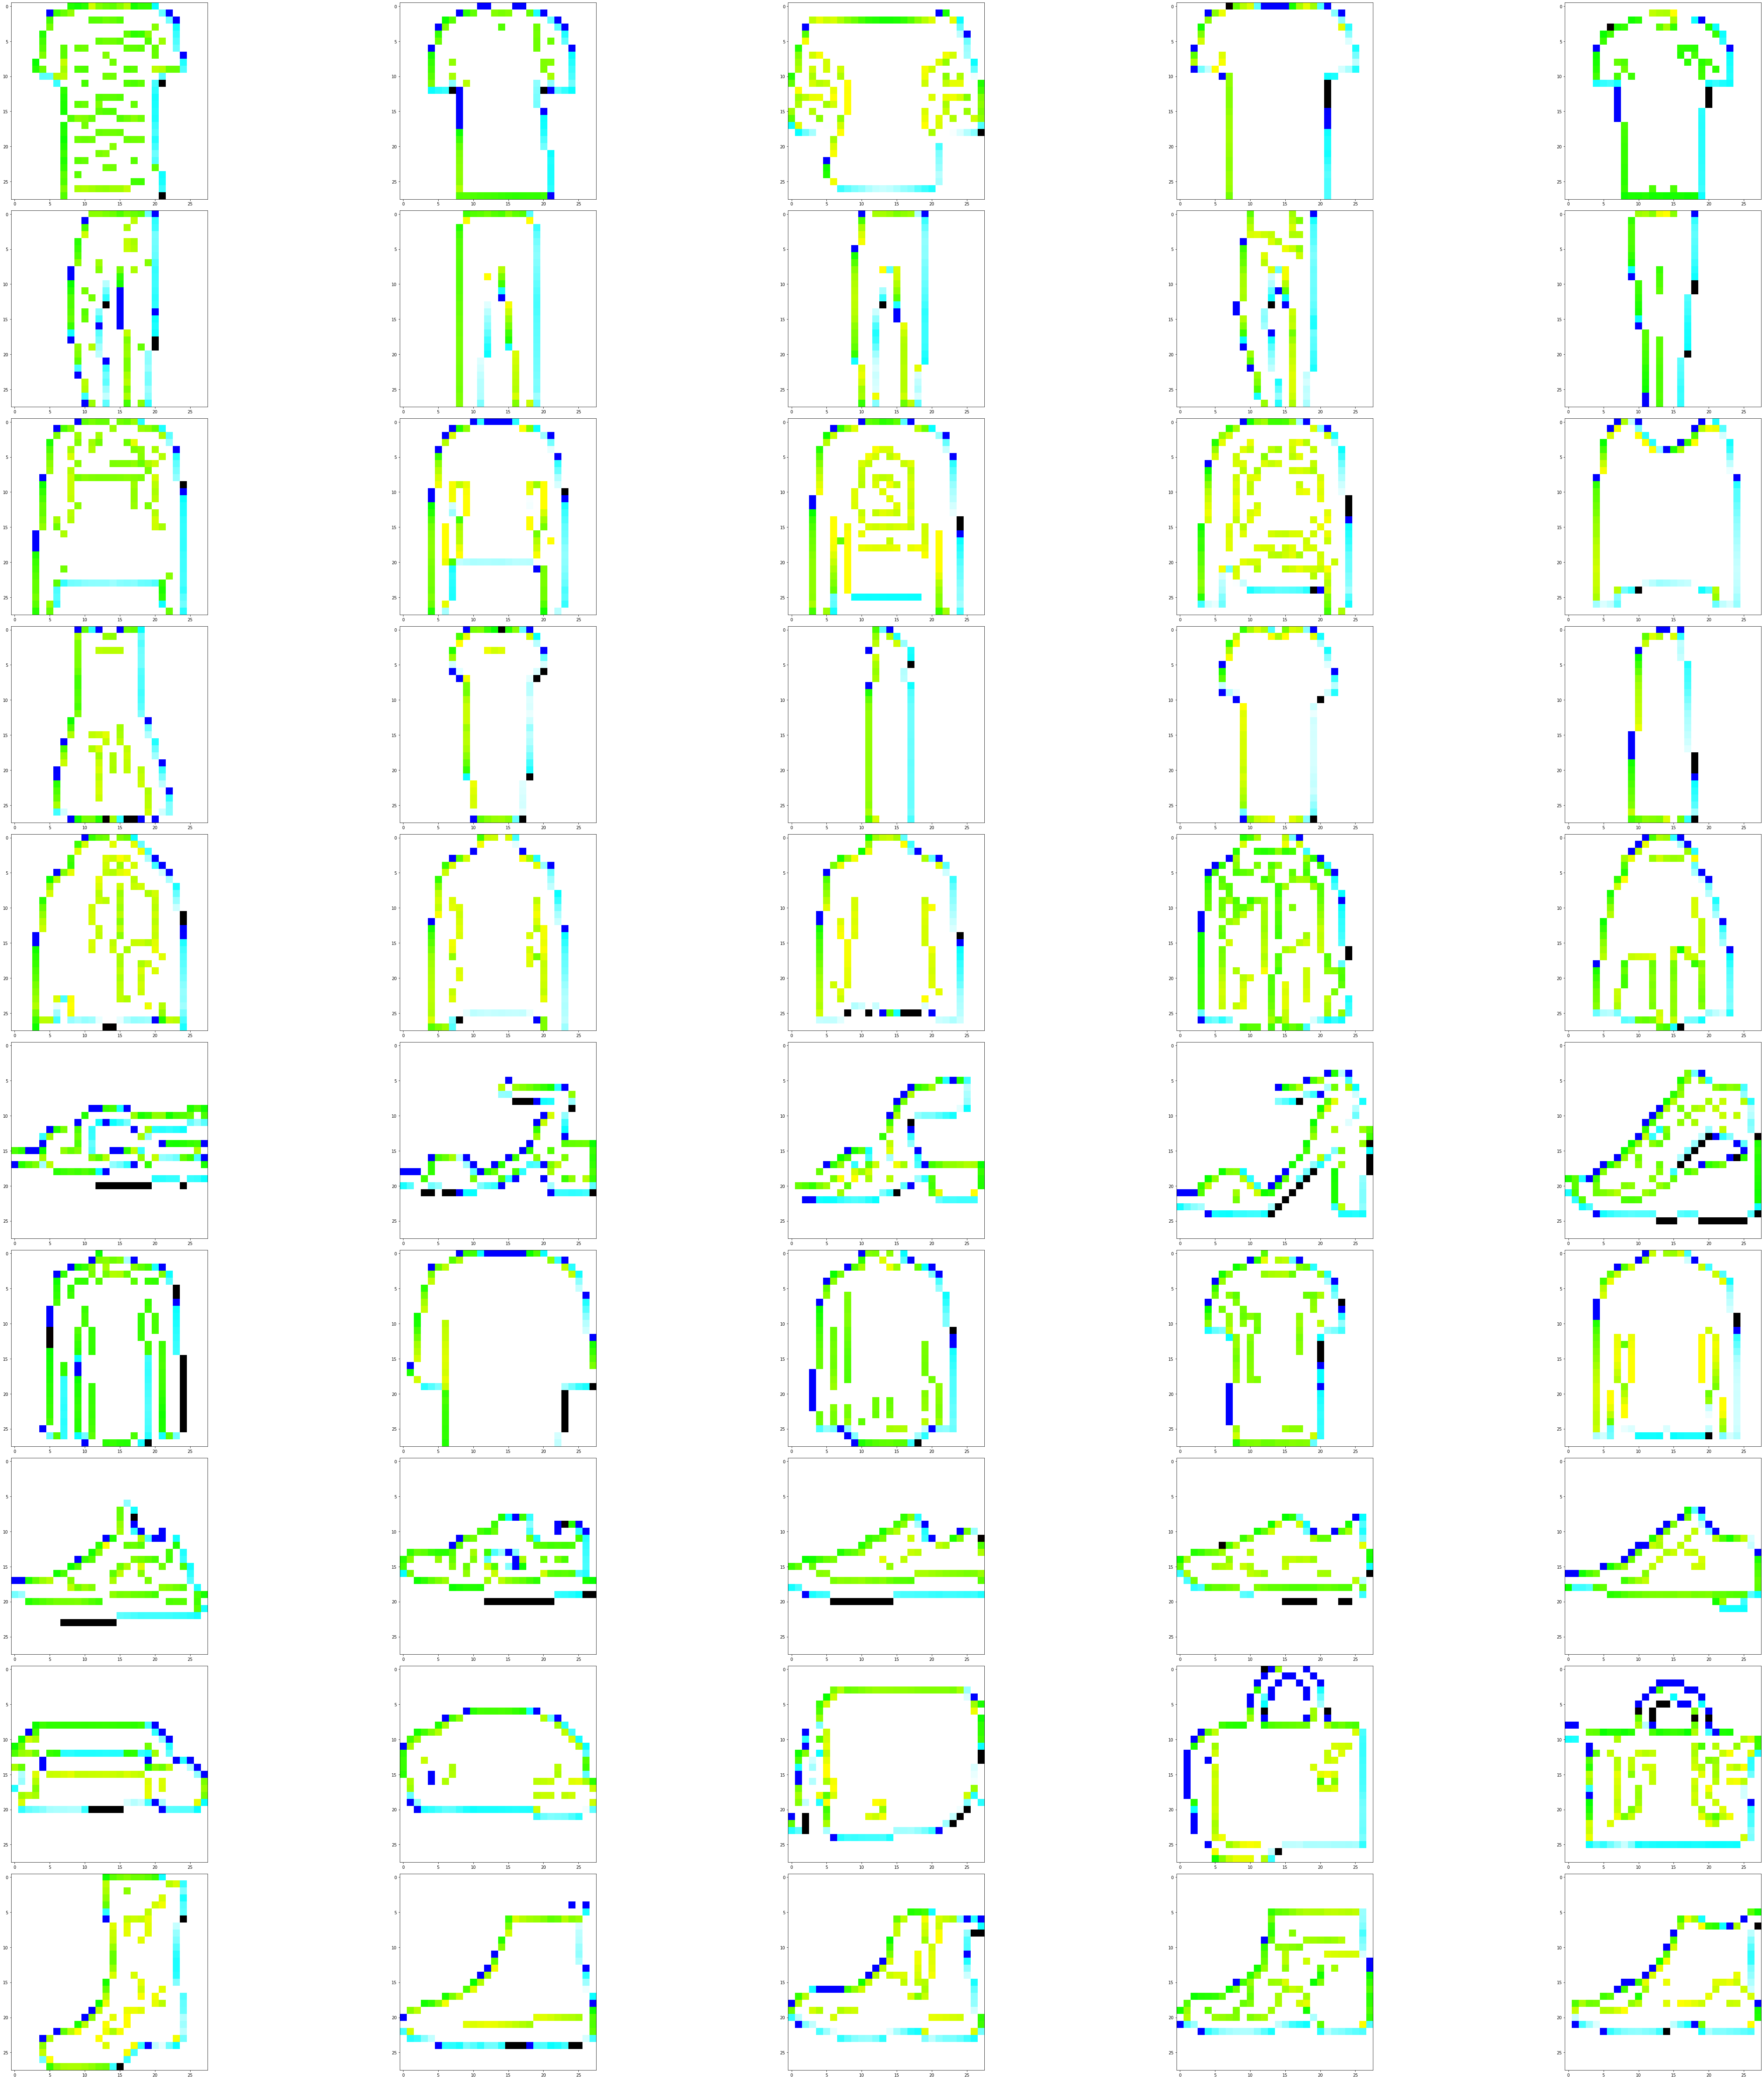

In [ ]:
np.random.seed(1) ##Set random seed so visualization results can be replicated
display_rand_samples(list(np.unique(y_train)),5,x_train_stack,y_train)

Ok so these are fairly interesting. Here are a couple of immediate observations I have:
* The bottoms of shoes and sandals seem to turn to a black color at their point nearest to the ground
* There are seemingly random blue pixels that pop up along the border of all objects, this could have some of the following impacts:
  * Introduce random noise so the model will generalize better to new noisy data
  * Cause the model to create meaningless features off these random blue pixels in training which could hinder generalizability
* Stacking the variation elimination image didn't seem to solidify the interior of the objects like I would have expected 

Now lets do the fun part and train a model to see the results of doing this. For fairness in comparison to the other results, I will use the same fashion model architecture that I have defined above, except I will make an adjustment so that the input shape is appropriate for our stacked image approach.  

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, GlobalAveragePooling2D, Dropout

##Create class for a model (considered more "expert" on tensorflow site)
class FashionModel2(Model):
    
    def __init__(self):
        
        super(FashionModel2, self).__init__()
        self.conv1 = Conv2D(28,(1,1),activation='relu',input_shape=(28,28,4))
        self.batch1 = BatchNormalization()
        
        self.conv2 = Conv2D(64,(3,3),activation='relu')
        self.batch2 = BatchNormalization()
        
        self.conv3 = Conv2D(128,(3,3),activation='relu')
        self.batch3 = BatchNormalization()
        
        self.globAvgPool = GlobalAveragePooling2D() ##Aids in regularization
        
        self.d1 = Dense(128, activation='relu')
        self.drop = Dropout(.5)
        self.d2 = Dense(20, activation='softmax')
        
    def call(self, x):
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.conv2(x)
        x = self.batch2(x)
        x = self.conv3(x)
        x = self.batch3(x)
        x = self.globAvgPool(x)
        x = self.d1(x)
        x = self.drop(x)
        return self.d2(x)

In [ ]:
##Create an instance of the model that will be used for grayscale variation
stackModel = FashionModel2()

In [ ]:
##Conduct a step of data normalization
x_train_stack, x_test_stack = x_train_stack / 255.0, x_test_stack / 255.0

##Perform train/validation split on the data
from sklearn.model_selection import train_test_split
x_train_stack, x_val_stack, y_train_stack, y_val = train_test_split(x_train_stack, y_train, test_size=0.25, random_state=42)

In [ ]:
##Compile the model
stackModel.compile(optimizer='adam',
                             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                             metrics=['accuracy'])

##Fit the model
stack_fit = stackModel.fit(x_train_stack, y_train_stack, 
                                          batch_size=32, epochs=50, validation_data=(x_val_stack, y_val))

Epoch 1/50
1407/1407 [==============================] - 51s 15ms/step - loss: 0.7730 - accuracy: 0.7223 - val_loss: 0.5050 - val_accuracy: 0.8215
Epoch 2/50
1407/1407 [==============================] - 20s 14ms/step - loss: 0.5295 - accuracy: 0.8111 - val_loss: 0.4324 - val_accuracy: 0.8393
Epoch 3/50
1407/1407 [==============================] - 20s 14ms/step - loss: 0.4655 - accuracy: 0.8327 - val_loss: 0.4476 - val_accuracy: 0.8350
Epoch 4/50
1407/1407 [==============================] - 20s 14ms/step - loss: 0.4225 - accuracy: 0.8493 - val_loss: 0.3856 - val_accuracy: 0.8589
Epoch 5/50
1407/1407 [==============================] - 20s 14ms/step - loss: 0.3921 - accuracy: 0.8583 - val_loss: 0.3661 - val_accuracy: 0.8660
Epoch 6/50
1407/1407 [==============================] - 20s 14ms/step - loss: 0.3666 - accuracy: 0.8689 - val_loss: 0.3786 - val_accuracy: 0.8624
Epoch 7/50
1407/1407 [==============================] - 20s 14ms/step - loss: 0.3500 - accuracy: 0.8742 - val_loss: 0.3045 -

Now it lets see how well this stacked approach generalizes to the test data:

In [ ]:
##Evaluate the testing accuracy of the model
print('Test Accuracy of Stacked Data Model:')
stackModel.evaluate(x_test_stack,  y_test, verbose=0)[1]

Test Accuracy of Stacked Data Model:


0.8824999928474426

So this Image Ensemble model does slightly worse than the model using the regular images with an accuracy of 88.25% compared to 90.21% accuracy. One interesting observation is that during training, the Image Ensemble hit an ending accuracy of 96.81% while the regular image model was at 93.92% for training. This indicates to me that by stacking the images on top of each other that I gave the Image Ensemble model a clearer path to overfit the data on. This higher training accuracy could also be because the Image Ensemble data had random blue pixels that could've been memorized when training, which wouldn't help it predict test data. Overall through, the image ensemble's test accuracy of 88.25% isn't bad considering top 10 accuracy on the Fashion MNIST dataset starts at 91.4% according to https://paperswithcode.com/sota/image-classification-on-fashion-mnist. 

## Final Thoughts

Overall I thought this was a pretty cool experimentation of manipulating input data to achieve superior robustness, inspired by the <b>Robustness</b> module covered in class. I had high hopes that there might be a new path to robustness outside of model architecture or adversarial image generation that could help a model generalize better and I am actually not discouraged by these results. Here are a couple of reasons for optimism:
* No models using image transformations saw significant over-fitting from the validation to test set
* The Image Ensemble achieved comparable accuracy of 88.25% to the model using un-transformed input
* It is likely the hypothesis that shape is a important feature for prediction of fashion items is correct given the gray-scale intensity elimination transformation performed well and only preserved shape information